## Graph Neural Architecture Search for Molecular Property Prediction

**Graph Neural Architecture Search:** 

The capability of Graph Neural Networks (**GNN**) to process graph data and excel on tasks ranging from node classification to link prediction has ensured choosing these model architectures as optimum tools for graph based datasets. [1], [2]. Given a search space *S* that consists of every possible model that could be built for a dataset *D*, the objective of Graph Neural Architecture Search is to find the best model s* ∈ *S*. The search space consists of all possible choices of various components that are crucial to build and train the **GNN** model. The computational time of running a Graph Neural Architecture search is therefore contingent on the available options.

For this hands-on session we are going to perform **Bayesian Optimization** (BO), which is a probabilistic method that calculates *posterioir* probabilities by combining a *prior* probability with a likelihood function.

**References**(s):

[1] https://www.ijcai.org/proceedings/2020/195

[2] https://ieeexplore.ieee.org/document/9645440




### Graph Neural Networks: Quick Recap

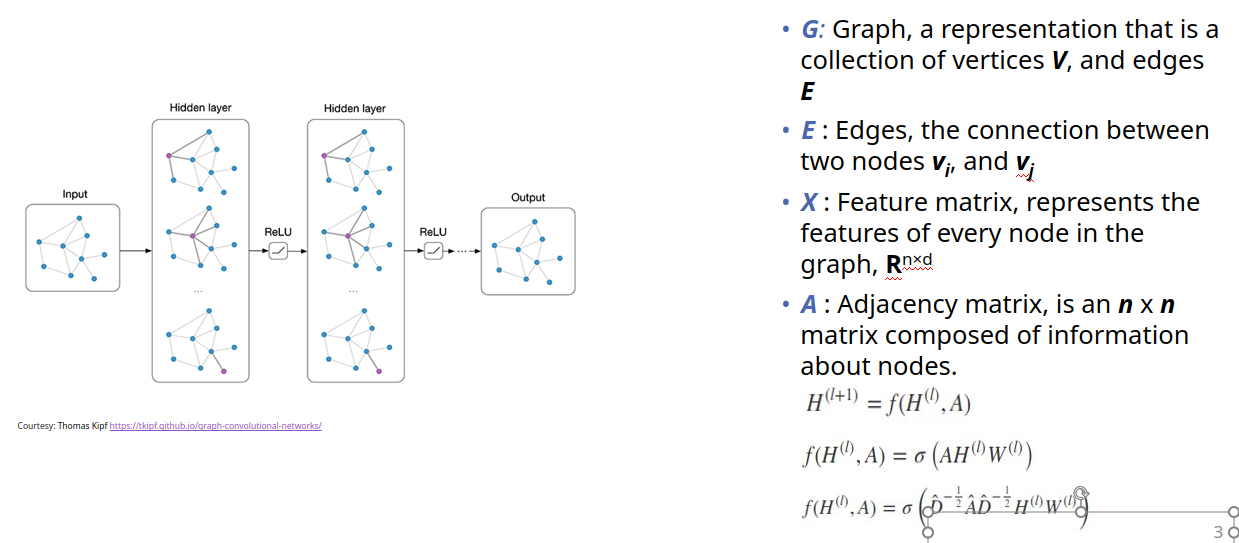

In [ ]:
#@title Install Pytorch Geometric + DeepHyper/MetalgPy
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# Install Pytorch Geometric
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Install DeepHyper/MetalgPy
!pip install -q metalgpy

# Install rdkit
!pip install -q rdkit-pypi

## MetalgPy in Action

In [ ]:
import metalgpy as mpy

@mpy.meta
def f(x):
    return x**2

# program is a symbol representing the call to f (original python code)
# where the input is a symbol representing a variable List (categorical decision variable)
program = f(mpy.Float(0, 10))
print("Program: ", program, end="\n\n")

# the choice method returns the variable symbols of the symbolized program
choices = program.choices()
print("Variable Space: ", choices)

# optimize the program
for i, eval in mpy.sample(program, size=100):

    sample_program = program.clone().freeze(eval.x)
    y = sample_program.evaluate()
    print(f"{i:02d} -> {sample_program} = {y}")

    eval.report(y)

## Transforming code into symbols

In [ ]:
@mpy.meta
class BinaryOperation:
  def __init__(self, op):
    self.op = op

  def __call__(self, x, y):
    if self.op == "+":
      return x + y
    elif self.op == "-":
      return x - y
    elif self.op == "*":
      return x * y
    elif self.op == "/":
      return x / y
    else:
      raise ValueError

meta_op = BinaryOperation(mpy.List(["+", "-", "*", "/"], name="op"))
meta_op

## Molecular property prediction

 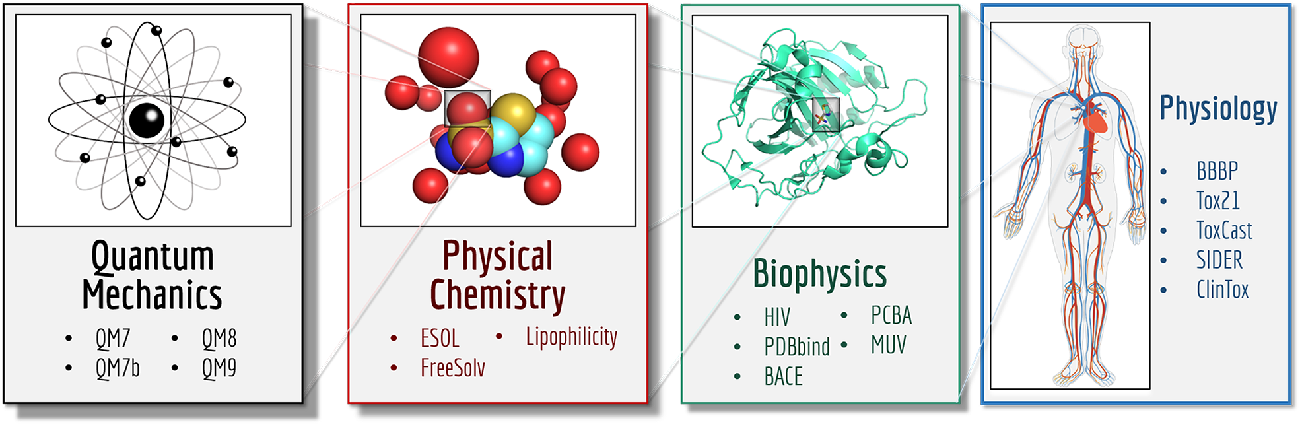

### Mini Batch multiple smaller graphs into a bigger graph

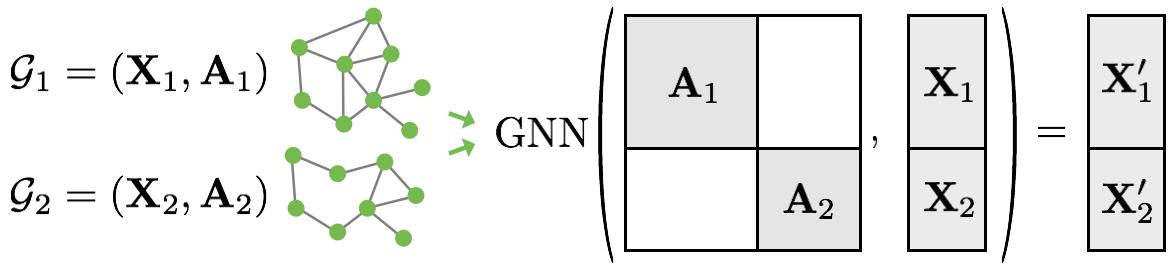

In [ ]:
#@title Import Libraries
# This Source Code Form is subject to the terms of the
# BSD 2-Clause "Simplified" License. If a copy of the same 
# was not distributed with this file, You can obtain one at
# https://github.com/deephyper/metalgpy/blob/master/LICENSE.

import timeit
import torch
import numpy as np
import metalgpy as mpy
import torch_geometric as pyg
from typing import Callable
from collections import defaultdict
from sklearn.metrics import *

# check if CUDA exists
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

In [ ]:
#@title Obtain FreeSolv graph into batches [train and test]
# define the helper method to load dataset
def load_molnet_graph_data(name, batch_size, training_split, seed=2022):
    """
    Load the specific Graph dataset from MoleculeNet
    Parameters
    ----------
    arg1 | name: str
        Name of the dataset to import from Pytorch Geometric MoleculeNet dataloader.
    arg2 | batch_size: int
        Batch size for creating the train/test dataloaders.
    arg3 | training_split: float
        Percentage of samples to be kept in training set.
    arg4 | seed: int
        Torch Random seed to ensure reproducibility. Default value is 2022
    Returns
    -------
    Pytorch Geometric Dataset(s)
        torch_geometric.datasets.molecule_net.MoleculeNet
    """
    # load the dataset
    dataset = pyg.datasets.MoleculeNet(root='/tmp/Molnet', name=name)

    # set the seed
    torch.manual_seed(seed)

    # shuffle the data
    dataset = dataset.shuffle()

    # set an stop index for gathering train data
    stop_index = int(np.floor(training_split*dataset.len()))

    # separate training data
    train_dataset = dataset[0:stop_index]

    # separate test data
    test_dataset = dataset[stop_index:]

    # create dataloaders for train and test samples
    train_loader = pyg.loader.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = pyg.loader.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return dataset, train_loader, test_loader

In [ ]:
#@title Load FreeSolv Data and mini batch

#@markdown Size of each mini batch
batch_size = 64 #@param {type:"slider", min:64, max:256, step:16}

#@markdown Training size
train_size = 0.8 #@param {type: "slider", min:0.7, max:0.8, step:0.01}

# load the freesolv data
dataset, train_loader, test_loader = load_molnet_graph_data("FreeSolv", batch_size, train_size)

# set the input node features
NUM_NODE_FEATURES = dataset.num_node_features

# set the edge features
NUM_EDGE_FEATURES = dataset.num_edge_features

# set the output channels
NUM_OUT_FEATURES = list(dataset)[0].y.shape[0]

# print the data
print(dataset)

### Build a simple Message Passing model

In [ ]:
#@title Template model for creating Message Passing Neural Networks
# define the MPNN class
class MPNN_mpy(torch.nn.Module):
    """
    Creates an MPNN model in pytorch geometric
    """
    def __init__(
            self,
            n_node_features: int,
            n_edge_features: int,
            n_hidden: int,
            n_output: int,
            MPNN_inp: torch.nn.Module,
            MPNN_hidden: torch.nn.Module,
            n_conv_blocks: int,
            skip_connection: str="plain") -> None:
        """
        Build the MPNN model
        Parameters
        ----------
        arg1 | n_node_features: int
            Number of features at node level
        arg2 | n_edge_features: int
            Number of features at edge level
        arg3 | n_hidden: int
            Number of hidden activations
        arg4 | n_output: int
            Number of output activations
        arg5 | n_conv_blocks: int
            Number of convolutional kernels
        Returns
        -------
        Nothing
            None
        """
        # super class the class structure
        super().__init__()
        
        # set the growth dimension
        self.growth_dimension = n_hidden

        # encode the node information
        self.node_encoder = MPNN_inp(n_node_features, n_hidden)

        # add the ability to add one or more conv layers
        conv_blocks = []

        # ability to add one or more conv blocks
        for block in range(n_conv_blocks):
            if skip_connection == "dense":
                self.growth_dimension = n_hidden + (n_hidden * block)
            conv = MPNN_hidden(self.growth_dimension, n_hidden)
            norm = torch.nn.LayerNorm(n_hidden, elementwise_affine=True)
            act = torch.nn.ReLU(inplace=True)
            layer = pyg.nn.DeepGCNLayer(conv, norm, act, block=skip_connection)
            conv_blocks.append(layer)

        # group all the conv layers
        self.conv_layers = torch.nn.ModuleList(conv_blocks)

        # add the linear layers for flattening the output from MPNN
        self.flatten = torch.nn.Sequential(
            torch.nn.Linear(self.growth_dimension, n_hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(n_hidden, n_output))
        
    def forward(self,
                x: torch.Tensor,
                edge_index: torch.Tensor,
                batch_idx: torch.Tensor) -> torch.Tensor:
        """
        Process the MPNN model
        Parameters
        ----------
        arg1 | x: torch.Tensor
            Input features at node level
        arg2 | edge_index: torch.Tensor
            Index pairs of verticies
        arg3 | batch_idx: torch.Tensor
            Batch index
        Returns
        -------
        Tensor
            torch.Tensor
        """
        # obtaint the input
        if isinstance(self.node_encoder, pyg.nn.MessagePassing):
            x = self.node_encoder(x, edge_index)
        else:
            x = self.node_encoder(x)

        # pass the node information to the conv layer
        x = self.conv_layers[0].conv(x, edge_index)

        # process the layers
        for layer in range(len(self.conv_layers[1:])):
            x = self.conv_layers[layer](x, edge_index)

        # obtain the output from the MPNN final layer
        y = pyg.nn.global_add_pool(x, batch=batch_idx)

        # pass the output to the linear output layer
        out = self.flatten(y)

        # return the output
        return out

In [ ]:
Linear = torch.nn.Linear
GCNConv = pyg.nn.GCNConv 
SAGEConv = pyg.nn.SAGEConv
GATConv = pyg.nn.GATConv

pyg_nn_layers = {"0": Linear, \
                        "1": GCNConv, \
                        "2": SAGEConv, \
                        "3": GATConv}


#@markdown Node Encoding Choices <br>{ $0$: `Linear`, $1$: `GCNConv`, $2$: `SAGEConv`, $3$: `GATConv` }
choice_inp = "0" #@param [0, 1, 2, 3]
# print("Node Encoding: ", pyg_nn_layers[choice_inp])

#@markdown Message Passing Layer Choices <br>{ $0$: `Linear`, $1$: `GCNConv`, $2$: `SAGEConv`, $3$: `GATConv` }
choice_hidden = "1" #@param [0, 1, 2]
# print("Message Passing Layer: ", pyg_nn_layers[str(int(choice)+1)])

#@markdown Number of channels for hidden layer
hidden_channels = 544 #@param {type:"slider", min:64, max:1024, step:32}
# print("# of channels for hidden layer: ", hidden_channels)

#@markdown Number of convolutional blocks
conv_blocks = 3 #@param {type:"slider", min:1, max:10, step:1}
# print("# of conv blocks for building the model: ", conv_blocks)

#@markdown Skip Connection Choices <br>{ $res$: `ResNet[Add]`, $dense$: `DenseNet[Concat]`, $plain$: `Plain` }
skip_conn_choice = "dense" #@param ["res", "dense", "plain"]

# build the model
model = MPNN_mpy(NUM_NODE_FEATURES, \
                 0, \
                 hidden_channels, \
                 1, \
                 pyg_nn_layers[choice_inp], \
                 pyg_nn_layers[choice_hidden], \
                 conv_blocks, skip_conn_choice)

# print the model
model

### Train and evaluate the simple model

In [ ]:
#@title Helper functions to train, evaluate, and obtain metrics
# define the helper method to train
def model_train(
        model: torch.nn.Module,
        dataloader: pyg.loader.DataLoader,
        learning_rate: float,
        ITERATIONS: int,
        optimizer: torch.optim.Optimizer,
        compute_loss: Callable,
        logging=False) -> torch.nn.Module:
    """
    Train the Pytorch Geometric model and return
    the model
    Parameters
    ----------
    arg1 | model: torch.nn.Module
        Trained Neural network model
    arg2 | dataloader: DataLoader
        Dataset as a DataLoader object
    arg3 | model: float
        Trained Neural network model
    arg4 | dataloader: int
        Dataset as a DataLoader object
    arg5 | model: torch.optim.Optimizer
        Trained Neural network model
    arg6 | dataloader: DataLoader
        Dataset as a DataLoader object
    Returns
    -------
    Pytorch model
        torch.nn.Module
    """
    for iteration in range(ITERATIONS):
        # set the model for training
        model.train()

        # iterate in batches over the training dataset
        for data in dataloader:
            # set the gradients to zero
            optimizer.zero_grad()

            # forward pass and compute the y hat values
            y_hat = model(data.x.float().to(device),
                          data.edge_index.long().to(device),
                          data.batch.long().to(device))

            # compute the mean squared error loss
            cost = compute_loss(y_hat, data.y.to(device))

            # compute mse loss again for the backward pass
            cost.backward()

            # update the weights
            optimizer.step()

        # display the stats
        if logging:
            print(f'Epoch: {iteration:03d}, Loss: {cost:.4f}')

    # return the tuple [Ground truth, Predictions]
    return model

# define the helper method to evaluate
def model_evaluate(
        model: torch.nn.Module,
        dataloader: pyg.loader.DataLoader,
) -> (torch.Tensor, torch.Tensor):
    """
    Evaluate the Pytorch model and return
    ground truth along with predictions
    Parameters
    ----------
    arg1 | model: torch.nn.Module
        Trained Neural network model
    arg2 | dataloader: DataLoader
        Dataset as a DataLoader object
    """
    # init an empty list to capture y hats
    y_preds = []

    # init an empty list to capture ground truth
    y_true = []

    # set the model to evaluate
    model.eval()

    # Iterate in batches over the test dataset.
    for data in test_loader:
        # store the ground truth
        y_true.append(data.y)

        # gather the model prediction
        out = model(data.x.float().to(device),
                    data.edge_index.long().to(device),
                    data.batch.long().to(device))

        # store the model predictions
        y_preds.append(torch.flatten(out, start_dim=1))

    # concat the predictions obtained in batches
    y_preds = torch.cat(y_preds)

    # concat the ground truth obtained in batches
    y_true = torch.cat(y_true)

    # return the tuple [Ground truth, Predictions]
    return (y_true, y_preds)

# define the helper method to obtain evaluation metrics
def regression_evaluation_metrics(
        y_true: torch.Tensor,
        y_preds: torch.Tensor,
        metric: str
) -> None:
    """
    Print the Pytorch model metrics based
    on the ground truth vs predictions
    Parameters
    ----------
    arg1 | y_true: torch.Tensor
        Ground truth values of the data
    arg2 | y_preds: torch.Tensor
        Model Predictions for the input data
    """
    # init an empty dict to store results
    results = defaultdict(dict)

    # store y_preds and y_true as numpy arrays
    y_true = y_true.detach().numpy()
    y_preds = y_preds.cpu().detach().numpy()

    # MSE
    results['mse'] = mean_squared_error(y_true, y_preds)

    # MAE
    results['mae'] = mean_absolute_error(y_true, y_preds)

    # RMSE
    results['rmse'] = mean_squared_error(y_true, y_preds, squared=False)

    # R2
    results['r2'] = r2_score(y_true, y_preds)

    # return appropriate metric(s)
    if metric == "all":
        return results
    if metric in results.keys():
        return results[metric]
    else:
        return defaultdict(dict)

In [ ]:
#@title Creating a template of Message Passing Network using DeepHyper/MetalgPy
n_inp_channels = NUM_NODE_FEATURES
n_out_channels = 1
Linear = mpy.meta(torch.nn.Linear)
GCNConv = mpy.meta(pyg.nn.GCNConv) 
SAGEConv = mpy.meta(pyg.nn.SAGEConv)
GATConv = mpy.meta(pyg.nn.GATConv)
max_layers = 5

meta_MPNN = mpy.meta(MPNN_mpy)

model = meta_MPNN(
    n_node_features=n_inp_channels,
    n_edge_features=0,
    n_hidden=mpy.Int(64, 1024, name="n_hidden"),
    n_output=n_out_channels,
    MPNN_inp=mpy.List([Linear, GCNConv, SAGEConv, GATConv], name="mpnn_inp"),
    MPNN_hidden=mpy.List([GCNConv, SAGEConv, GATConv], name="mpnn_hidden"),
    n_conv_blocks=mpy.Int(1, 10, name="n_conv_blocks"),
    skip_connection=mpy.List(["res", "dense", "plain"], ordered=False, name="skip_conn_choice")
)

model

In [ ]:
# get a random number for seed
seed = 42

# print the seed
print("Seed:", seed)

# use the seed to set the random state
rng = np.random.RandomState(seed)

# sample 5 sample configurations
for i, pyg_model_space in mpy.sample(model, size=5, rng=rng):
  # obtain a sample model
  sample_model = model.clone().freeze(pyg_model_space.x)

  # display the model config
  print("-----------------")
  print(pyg_model_space.x)
  print(sample_model.evaluate())
  print("-----------------\n")

In [ ]:
#@title GNN Model training hyperparameters

# set the loss function for training
loss_fn = torch.nn.MSELoss()

# set the learning rate for the function

#@markdown Number of epochs
lr = 0.01 #@param {type:"slider", min:0.001, max:0.1, step:0.001}

# set number of epochs
#@markdown Number of epochs
EPOCHS = 100 #@param {type:"slider", min:100, max:1000, step:10}

In [ ]:
#@title Helper function to train, evaluate, and record metrics

# helper function to train, evaluate, and record metrics
def train_eval(eval_model):
  # records the time at this instant of the program
  train_time_start = timeit.default_timer()

  # train the model
  eval_model = model_train(eval_model.to(device), \
                              train_loader, \
                              lr, \
                              EPOCHS, \
                              torch.optim.Adam(eval_model.parameters(), lr = lr),\
                              loss_fn, logging=False)
  
  # records the time at this instant of the program
  train_time_end = timeit.default_timer()
  
  # store the value
  model_train_time = train_time_end-train_time_start
  
  # obtain the predictions
  y_true, y_preds = model_evaluate(eval_model.to(device), test_loader)
  
  # obtain the evaluation metrics
  y = regression_evaluation_metrics(y_true, y_preds, 'rmse')
  model_eval_results = regression_evaluation_metrics(y_true, y_preds, 'all')

  # return the results
  return y, model_eval_results, model_train_time

In [ ]:
# store the results in a list
results = []

# sample and optimize the pyg symbols
for i, pyg_model_space in mpy.sample(model, size=10, rng=rng):
  # obtain a model
  sample_model = model.clone().freeze(pyg_model_space.x)

  # evaluate the model
  eval_model = sample_model.evaluate()

  # display the model config
  print("-----------------")
  print(pyg_model_space.x)
  print(eval_model)

  # train, eval, obtain metrics
  y, model_eval_results, model_train_time = train_eval(eval_model)

  # report the model
  pyg_model_space.report(y)

  # store the results
  results.append((pyg_model_space.x, y, model_eval_results, model_train_time))
  
  # display the stats
  print(f'ITER: {i:03d}, Objective: {y:.4f}\n')
  print("-----------------\n")